In [1]:
# import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [4]:
# Define company name and date ranges

In [5]:
# CHANGE ME
COMPANY_IDENTIFIER = 'CSC'
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [6]:
print('This report is for ' + COMPANY_IDENTIFIER + ' from ' + TRANSFER_PACKAGES_START_DATE)

This report is for CSC from 2020-01-01


In [7]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

# Download History Checks

## Check download status summaries

In [8]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [9]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [10]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000918-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-01-18

Verifying download summaries for license C10-0000670-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-01-18

[SUCCESS] All download summaries look good!


## Get list of retailer license numbers

In [14]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000670-LIC,Retailer,"DISPLEASED MARMOT, LLC",True,Active,CA-04155,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,None
1,CA,C10-0000918-LIC,Retailer,Gnarly Narwhal LLC,True,Active,CA-06173,Retailer,977dbaa4-81e5-4c4d-afd7-622506a05e93,None


In [11]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())

In [12]:
license_numbers

['C10-0000670-LIC', 'C10-0000918-LIC']

In [20]:
#company_sales_transactions_dataframe[company_sales_transactions_dataframe['license_number'] == 'C10-0000918-LIC']

In [13]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

## Unknown transfer packages

In [21]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [22]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[FAILURE] Found a total of 577 unknown transfer packages


577

In [23]:
# Plot incoming transfer packages

In [24]:
#company_incoming_transfer_packages_dataframe['created_month'] = pd.to_datetime(company_incoming_transfer_packages_dataframe['created_date']).dt.strftime('%Y-%m')

In [25]:
# Incoming transfer packages by shipment type name
#company_incoming_transfer_packages_dataframe.groupby(['created_month', 'shipment_type_name'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True)

In [26]:
# Incoming transfer packages by shipment_transaction_type
#company_incoming_transfer_packages_dataframe.groupby(['created_month', 'shipment_transaction_type'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True)

In [27]:
# Incoming transfer packages by product category names
#company_incoming_transfer_packages_dataframe.groupby(['created_month', 'product_category_name'])['package_id'].count().unstack().plot.bar(figsize=(24, 8), stacked=True,colormap='Paired')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Receiver wholesale price coverage

In [28]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [29]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


98.0% of incoming transfer packages have receiver wholesale price


In [ ]:
# Plot Sales GMV month-over-month 

In [ ]:
#company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [ ]:
#company_sales_receipts_dataframe.groupby(['sales_month'])['receipt_number'].count().plot.bar(figsize=(24, 8))

In [ ]:
#company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

In [ ]:
## Sales GMV month-over-month from metrc_sales_transactions

In [ ]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [ ]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [ ]:
# Sales GMV month-over-month by product category name
#deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month', 'tx_product_category_name'])['tx_total_price'].sum().unstack().plot.bar(figsize=(24, 8), stacked=True,colormap = 'Paired')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



In [30]:
## View consumer vs medicinal breakdown by month.
is_sales_customer_type_breakdown_visible = False
result = None
if is_sales_customer_type_breakdown_visible:
    result = company_sales_receipts_dataframe.groupby(['sales_month', 'sales_customer_type'])['total_price'].sum().unstack().plot.bar(figsize=(24, 8), stacked=True)
result

## Trxns missing incoming transfer packages

In [31]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [32]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [33]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 8833 (3.971976275164918%)
# transactions total: 222383


In [34]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
#month_to_missing_count


## Receipts missing metrc_sales_transactions

In [35]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [36]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.1
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 11 (0.009074709609292502%)
# receipts total: 121216


In [37]:
#month_to_missing_count

In [38]:
for example_mismatch_over_receipt in example_mismatch_over_receipts[:10]:
    receipt_number, receipt_transactions = example_mismatch_over_receipt
    first_receipt_transaction = receipt_transactions[0]
    print(receipt_number)
    for receipt_transaction in receipt_transactions:
        print(receipt_transaction)
    print('---')

# Vendor churn

In [45]:
window = 4

In [ ]:
#df_vendor_churn = company_incoming_transfer_packages_dataframe

In [46]:
license_number = license_numbers[0]
df_vendor_churn = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == license_number]
df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))


In [47]:
# make `vc` a long-table version of the spreadsheet, where all conpanies have a continuous year_month starting from 
# 2020-01-01 to 2022-01-01

vc_full = (
    vc
    .groupby('shipper_facility_name').apply(
        lambda df: df.merge(
        pd.Series(
            None, 
            index = pd.date_range(start='2020-01-01', end='2022-01-01', freq = 'MS'), 
            name='__place_holder'
        ), 
        how ='right',
        left_on = 'year_month', 
        right_index=True,
    ).assign(
        **{
            "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
            "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
        }
    )
    .drop('__place_holder', axis=1)
    )
).reset_index(drop=True)

In [48]:
#vc_full

In [49]:
rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(window).sum()
)
rolling_4m_sum.columns = ['rolling_4m_total_price']


facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
)
facility_monthly_running_total.columns = ['facility_running_total']

monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
monthly_running_total.columns = ['monthly_running_total']


In [50]:
vc_result = rolling_4m_sum.merge(
    facility_monthly_running_total,
    how='inner',
    left_index=True,
    right_index=True
).reset_index().merge(
    monthly_running_total,
    how='left',
    on = 'year_month'
)

In [51]:
vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']

In [52]:
vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0

In [53]:
vc_result ['significant'] = vc_result['%_total'] > 0.001

In [55]:
vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)

In [56]:
churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
churn.columns = ['year_month','%_inactive']
churn.index = churn.year_month



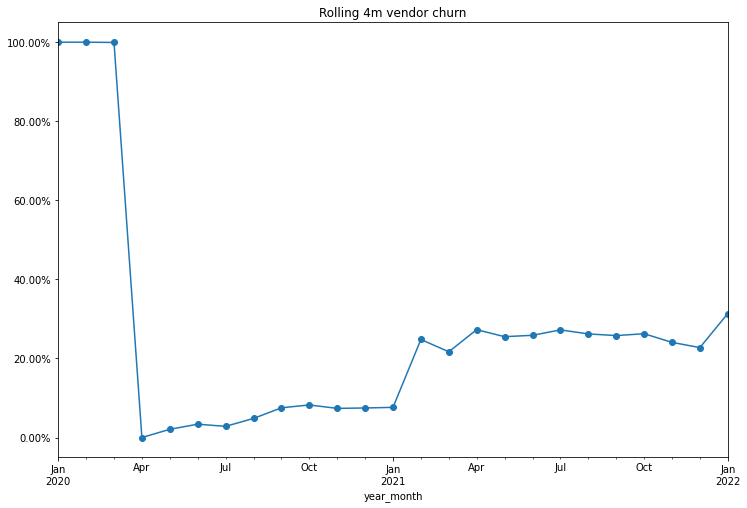

In [223]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')

In [224]:
churn

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.999963
2020-02-01,2020-02-01,0.999971
2020-03-01,2020-03-01,0.999297
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.020754
2020-06-01,2020-06-01,0.033740
2020-07-01,2020-07-01,0.028241
2020-08-01,2020-08-01,0.048287
2020-09-01,2020-09-01,0.075154


In [226]:
VC_MONTH_LIST = ['2021-09-01','2021-10-01','2021-11-01','2021-12-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [228]:
# output vendor churn matrix
vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
vc_data['year_month'] = vc_data['year_month'].astype(str)
vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
                    columns='year_month', fill_value=0).reset_index()

In [229]:
vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)

In [242]:
vc_matrix[vc_matrix['shipper_facility_name'] == 'NABITWO, LLC']

year_month,shipper_facility_name,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure
98,"NABITWO, LLC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15011.48,20673.45,23720.36,28913.47,36691.13,23855.95,32302.65,32760.5,22813.31,31471.85,23512.83,26531.25,25977.13,344235.36,3260942.32,0.105563,107493.06,True,True,Active


In [240]:
vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
vc_matrix['measure'] = vc_matrix.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)

In [245]:
#vc_matrix.to_csv('vc_matrix.csv')

# Receiver wholesale price outlier check

In [64]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort.dropna()["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    #print('printing per unit incoming by product name summary ...')
    #print(f'max per unit incoming: {per_unit_incoming_product_sort["per_unit_incoming"][0]}' + f' from product name: {per_unit_incoming_product_sort["product_name"][0]}')
    #print(f'min per unit incoming: {per_unit_incoming_product_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from product_name: {per_unit_incoming_product_sort.dropna()["product_name"][-1:].values[0]}')
    #print(per_unit_incoming_product_top5)
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [65]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 300.0 from package ID: 17867556
min per unit incoming: 3.90625e-05 from package ID: 12252383



In [66]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(5)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,17867556,300.0
1,21232050,175.0
2,3818405,132.0
3,14420347,110.0
4,14420349,110.0


In [67]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
13137,13980310,0.000067
13138,8825277,0.000050
13139,12638851,0.000049
13140,12252505,0.000039
13141,12252383,0.000039


## Trim outliers in per unit incoming before COGS analysis
Trim the packages from incoming transfer data which per unit incoming is in the top and bottom 0.5% 

In [68]:
keep= company_incoming_transfer_packages_dataframe['per_unit_incoming'].between(company_incoming_transfer_packages_dataframe['per_unit_incoming'].quantile(.005), company_incoming_transfer_packages_dataframe['per_unit_incoming'].quantile(.995))



In [69]:
# date with trimmed packages
#company_incoming_transfer_packages_dataframe[['per_unit_incoming','created_date']][~keep].groupby(['created_date']).count()

In [70]:
company_incoming_transfer_packages_dataframe_trim = company_incoming_transfer_packages_dataframe[keep]

In [71]:
print('Trimmed ' + str(round((1 - keep.sum() / keep.shape[0])*100,2)) + '%, '  + str(keep.shape[0] - keep.sum()) + ' of ' + str(keep.shape[0])+' total packages')

Trimmed 2.51%, 336 of 13370 total packages


In [72]:
# show break down by month the trimmed records
#display the last few weeks updated margin %

# COGS analysis

In [73]:
def cogs_analysis(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [98]:
df_in = company_incoming_transfer_packages_dataframe # use trimmed
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [99]:
df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_out,df_inventory,df_sales,'monthly')
df_summary_simp.index = df_summary_simp.date


In [100]:
# rolling
rolling_4m_margin = df_summary_simp[['margin_%']].rolling(4).mean()
rolling_4m_margin.columns = ['rolling_4m_margin_%']

In [101]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage
date,,,,,,,,,
2020-01,2020-01,19604.36,11673.820401,7930.539599,0.404529,1080.0,22.0,1058,0.936687
2020-02,2020-02,89270.77,47377.240076,41893.529924,0.469286,4500.0,253.0,4247,0.927644
2020-03,2020-03,168489.95,86926.783796,81563.166204,0.484083,7224.0,240.0,6984,0.938182
2020-04,2020-04,151237.68,85866.246408,65371.433592,0.432243,6638.0,77.0,6561,0.972601
2020-05,2020-05,182498.47,91623.286387,90875.183613,0.497950,7484.0,37.0,7447,0.944353
2020-06,2020-06,188586.83,97423.355644,91163.474356,0.483403,7765.0,115.0,7650,0.945107
2020-07,2020-07,203898.82,105382.630240,98516.189760,0.483162,8517.0,60.0,8457,0.959014
2020-08,2020-08,204958.60,104596.717341,100361.882659,0.489669,8543.0,119.0,8424,0.974005
2020-09,2020-09,199991.59,101372.750412,98618.839588,0.493115,8069.0,11.0,8058,0.976167


In [103]:
df_summary_simp.to_csv('csc_2021_12.csv')

## Monthly 

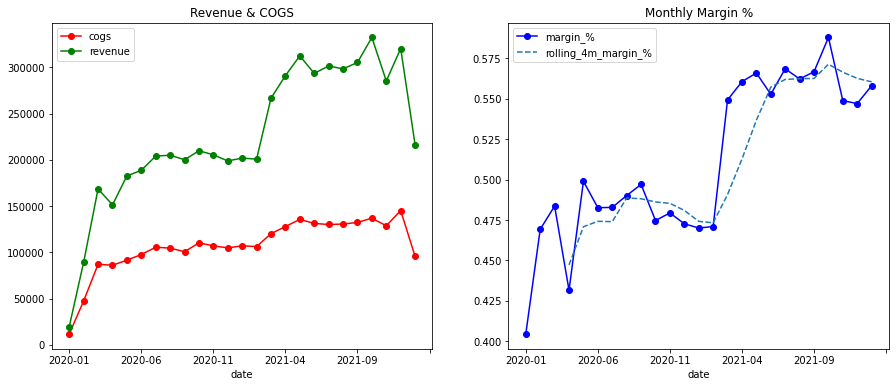

In [78]:
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
df_summary_simp['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
df_summary_simp['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
axes[0].set_title("Revenue & COGS")
axes[0].legend()
# plot second pandas frame in subplot style
df_summary_simp['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
rolling_4m_margin['rolling_4m_margin_%'].plot(ax = axes[1],subplots=True,style='--')
axes[1].legend()
axes[1] = plt.title('Monthly Margin %')

## Monthly overlay

In [79]:
df_summary_simp_2021 = df_summary_simp[(df_summary_simp['date'] >= '2021-01')&(df_summary_simp['date'] <= '2021-12')]
df_summary_simp_2020 = df_summary_simp[(df_summary_simp['date'] >= '2020-01')&(df_summary_simp['date'] <= '2020-12')]
df_summary_simp_2022 = df_summary_simp[(df_summary_simp['date'] >= '2022-01')&(df_summary_simp['date'] <= '2022-12')]

In [80]:
df_summary_simp_2020['month'] = pd.to_datetime(df_summary_simp_2020['date']).dt.strftime("%m")
df_summary_simp_2021['month'] = pd.to_datetime(df_summary_simp_2021['date']).dt.strftime("%m")
df_summary_simp_2022['month'] = pd.to_datetime(df_summary_simp_2022['date']).dt.strftime("%m")

In [81]:
df_summary_simp_2020.reset_index(drop=True, inplace=True)
df_summary_simp_2021.reset_index(drop=True, inplace=True)
df_summary_simp_2022.reset_index(drop=True, inplace=True)

In [82]:
df_summary_simp_overlay_temp = df_summary_simp_2021.merge(df_summary_simp_2020,on = 'month',how = 'left',suffixes=['_2021','_2020'])
#df.index = df.month

In [83]:
df_summary_simp_overlay = df_summary_simp_overlay_temp.merge(df_summary_simp_2022,on = 'month',how = 'left',suffixes=['_2021','_2020','_2022'])

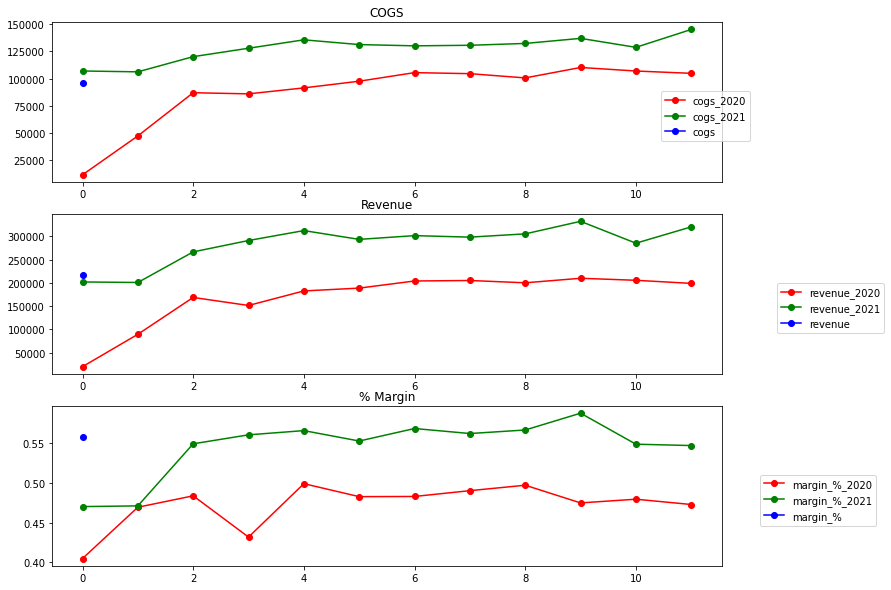

In [84]:
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12,10))
# plot first pandas frame in subplot style
df_summary_simp_overlay['cogs_2020'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
df_summary_simp_overlay['cogs_2021'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-')
df_summary_simp_overlay['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='b-')

axes[0].set_title("COGS")
axes[0].legend(bbox_to_anchor = (1.05, 0.6))
df_summary_simp_overlay['revenue_2020'].plot(ax = axes[1],subplots=True,marker = 'o',style='r-',) 
df_summary_simp_overlay['revenue_2021'].plot(ax = axes[1],subplots=True,marker = 'o',style='g-',) 
df_summary_simp_overlay['revenue'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
axes[1].set_title("Revenue")
axes[1].legend(bbox_to_anchor = (1.25, 0.6))
df_summary_simp_overlay['margin_%_2020'].plot(ax = axes[2],subplots=True,marker = 'o',style='r-',) 
df_summary_simp_overlay['margin_%_2021'].plot(ax = axes[2],subplots=True,marker = 'o',style='g-',) 
df_summary_simp_overlay['margin_%'].plot(ax = axes[2],subplots=True,marker = 'o',style='b-')
axes[2].set_title("% Margin")
ax = axes[2].legend(bbox_to_anchor = (1.05, 0.6))

In [ ]:
## Monthly since 2021

In [ ]:
#df_summary_simp_2021.index = df_summary_simp_2021.date

In [ ]:
#create subplot figure with having two side by side plots
#fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
#df_summary_simp_2021['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
#df_summary_simp_2021['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
#axes[0].set_title("Revenue & COGS")
#axes[0].legend()
# plot second pandas frame in subplot style
#df_summary_simp_2021['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
#axes[1].legend()
#axes[1] = plt.title('Monthly Margin %')

In [ ]:
#df_summary_simp_2021

In [ ]:
#df_summary_simp.to_csv('./dw_monthly.csv')

## Weekly

In [85]:
df_summary_simp_weekly,df_cogs_average_product_weekly = cogs_analysis(df_in,df_out,df_inventory,df_sales,'weekly')
df_summary_simp_weekly.index = df_summary_simp_weekly.date


In [86]:
# rolling
rolling_4w_margin = df_summary_simp_weekly[['margin_%']].rolling(4).mean().reset_index()
rolling_4w_margin.columns = ['date','rolling_4w_margin_%']
rolling_4w_margin.index = rolling_4w_margin.date

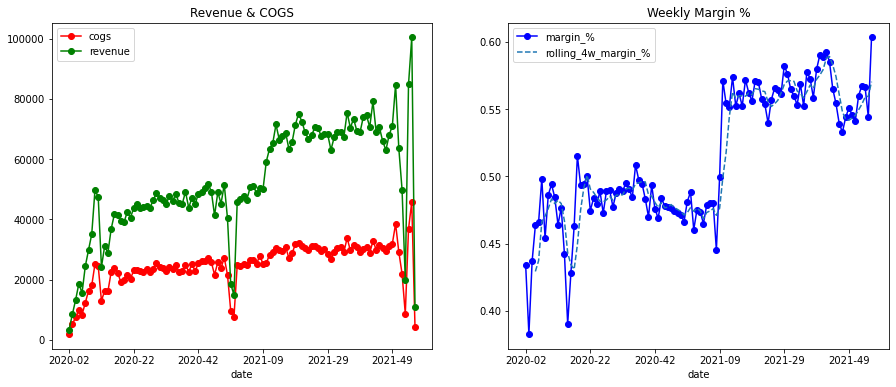

In [87]:
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
df_summary_simp_weekly['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
df_summary_simp_weekly['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
axes[0].set_title("Revenue & COGS")
axes[0].legend()
# plot second pandas frame in subplot style
df_summary_simp_weekly['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
rolling_4w_margin['rolling_4w_margin_%'].plot(ax = axes[1],subplots=True,style='--')
axes[1].legend()
axes[1] = plt.title('Weekly Margin %')

In [ ]:
#df_summary_simp_weekly_2021 = df_summary_simp_weekly[df_summary_simp_weekly['date'] >= '2021-01']

In [ ]:
## Weekly since 2021

In [ ]:
#create subplot figure with having two side by side plots
#fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
#df_summary_simp_weekly_2021['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
#df_summary_simp_weekly_2021['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
#axes[0].set_title("Revenue & COGS")
#axes[0].legend()
# plot second pandas frame in subplot style
#df_summary_simp_weekly_2021['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
#axes[1] = plt.title('Weekly Margin %')

## Recent weeks in 2022

In [88]:
df_summary_simp_weekly[df_summary_simp_weekly['date'] >= '2022-01'][['date','revenue','cogs','margin_%','coverage']]

,date,revenue,cogs,margin_%,coverage
date,,,,,
2022-01,2022-01,84826.66,36772.614218,0.566497,0.946162
2022-02,2022-02,100389.55,45746.678056,0.544308,0.942775
2022-03,2022-03,11013.41,4370.015594,0.603210,0.919799


In [89]:
rolling_4w_margin[rolling_4w_margin['date'] >= '2022-01']

,date,rolling_4w_margin_%
date,,
2022-01,2022-01,0.558810
2022-02,2022-02,0.559542
2022-03,2022-03,0.570348


# Items sold at discount (sales price < cost)

In [90]:
def calculate_discount(df_sales_with_incoming_filled:pd.DataFrame) -> pd.DataFrame:
    # receipt count
    total_receipt_count = df_sales_with_incoming_filled.groupby(['date']).apply(lambda x: len(x['receipt_number'].unique()))
    discounted = df_sales_with_incoming_filled[(df_sales_with_incoming_filled['per_unit_incoming'] > df_sales_with_incoming_filled['per_unit'])|(df_sales_with_incoming_filled['per_unit_product'] > df_sales_with_incoming_filled['per_unit'])]
    total_discounted_receipt_count = discounted[['date','receipt_number']].groupby(['date']).apply(lambda x: len(x['receipt_number'].unique()))
    discount_rate = total_discounted_receipt_count / total_receipt_count
    discount_rate_df = pd.DataFrame([total_receipt_count,total_discounted_receipt_count,discount_rate]).T.reset_index()
    discount_rate_df.columns = ['date','total_receipt_count','total_discounted_receipts_count','discount_rate']

    # dollar amount
    total_receipt_amount = df_sales_with_incoming_filled[['date','tx_total_price']].groupby(['date']).sum().reset_index()
    total_receipt_amount.columns = ['date','total_receipt_amount']
    total_discounted_receipt_amount = discounted[['date','tx_total_price']].groupby(['date']).sum().reset_index()
    total_discounted_receipt_amount.columns = ['date','total_discounted_receipt_amount']
    discount_rate_dollar_df = total_receipt_amount.merge(total_discounted_receipt_amount,on = 'date',how = 'left')
    discount_rate_dollar_df['discount_rate_dollar'] = discount_rate_dollar_df['total_discounted_receipt_amount'] / discount_rate_dollar_df['total_receipt_amount']
    discount_df = discount_rate_df.merge(discount_rate_dollar_df, on = 'date',how = 'left')
    discount_df.index = discount_df.date
    return discount_df
                                                                                                                                           
                                                                                                                                           
                                                                                                                                           

In [91]:
discount_rate_monthly = calculate_discount(df_cogs_average_product)
discount_rate_weekly = calculate_discount(df_cogs_average_product_weekly)

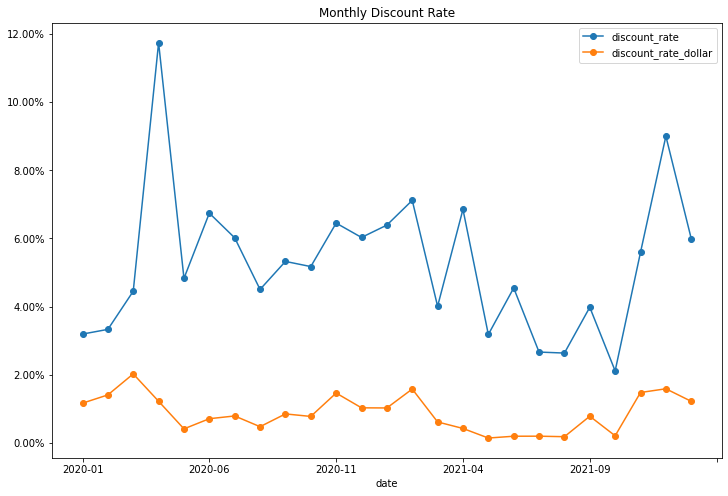

In [92]:
ax = discount_rate_monthly[['discount_rate','discount_rate_dollar']].fillna(0).plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Monthly Discount Rate')

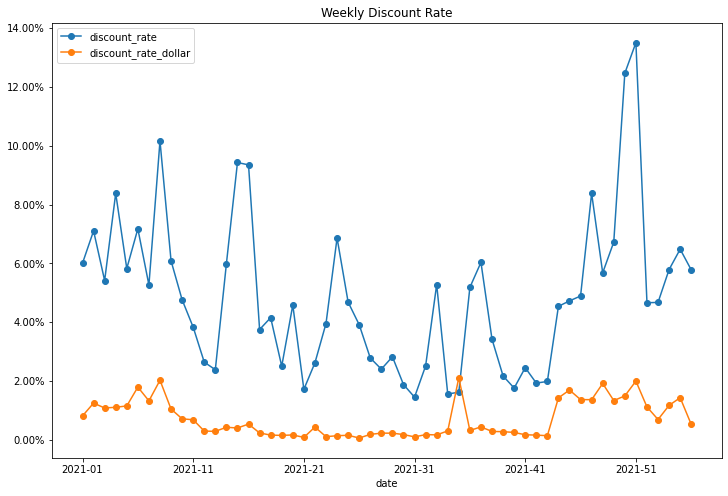

In [93]:
ax = discount_rate_weekly[discount_rate_weekly['date'] >= '2021-01'].fillna(0)[['discount_rate','discount_rate_dollar']].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Weekly Discount Rate')

# Items refunded (transaction total < 0)

In [94]:
def calculate_refund(df_sales_with_incoming_filled:pd.DataFrame) -> pd.DataFrame:
    #total receipt count
    count_receipt = df_sales_with_incoming_filled[['date','receipt_number']].groupby(['date']).apply(lambda x: len(x['receipt_number'].unique()))
    refunded = df_sales_with_incoming_filled[df_sales_with_incoming_filled['tx_total_price'] < 0]
    count_refund_receipt = refunded[['date','receipt_number']].groupby(['date']).apply(lambda x: len(x['receipt_number'].unique()))
    refund_rate = count_refund_receipt / count_receipt
    refund_rate_df = pd.DataFrame([count_receipt,count_refund_receipt,refund_rate]).T.reset_index()
    refund_rate_df.columns = ['date','total_receipt_count','total_refunded_receipts_count','refund_rate']
    
    # dollar amount
    total_receipt_amount = df_sales_with_incoming_filled[['date','tx_total_price']].groupby(['date']).sum().reset_index()
    total_receipt_amount.columns = ['date','total_receipt_amount']
    total_refunded_receipt_amount = refunded[['date','tx_total_price']].groupby(['date']).sum().reset_index()
    total_refunded_receipt_amount.columns = ['date','total_refunded_receipt_amount']
    refund_rate_dollar_df = total_receipt_amount.merge(total_refunded_receipt_amount,on = 'date',how = 'left')
    refund_rate_dollar_df['refund_rate_dollar'] = refund_rate_dollar_df['total_refunded_receipt_amount'] * -1.00 / refund_rate_dollar_df['total_receipt_amount']
    refund_df = refund_rate_df.merge(refund_rate_dollar_df, on = 'date',how = 'left')
    refund_df.index = refund_df.date
    return refund_df


In [95]:
refund_rate_monthly = calculate_refund(df_cogs_average_product)
refund_rate_weekly = calculate_refund(df_cogs_average_product_weekly)

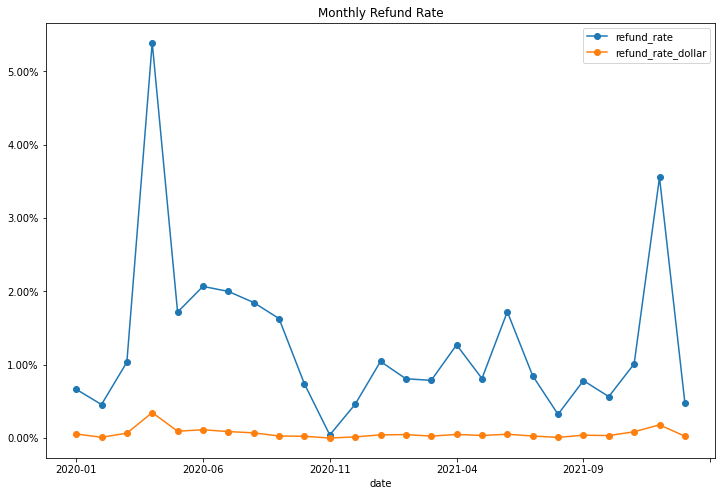

In [96]:
ax = refund_rate_monthly[['refund_rate','refund_rate_dollar']].fillna(0).plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Monthly Refund Rate')

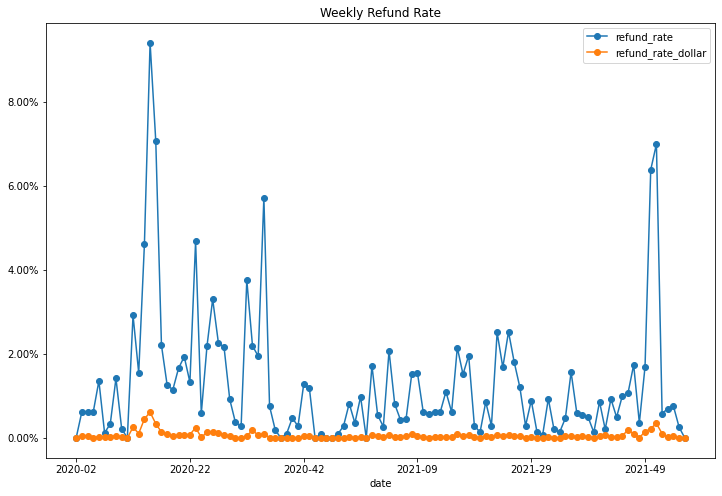

In [97]:
ax = refund_rate_weekly[['refund_rate','refund_rate_dollar']].fillna(0).plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Weekly Refund Rate')

# COGS analysis with further filldown using product category name

In [ ]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    df_summary_simp.index = df_summary_simp.date
    return df_summary_simp,df_cogs_average_product_cat




In [ ]:
df_in = company_incoming_transfer_packages_dataframe_trim
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'monthly')
df_summary_simp_cat_weekly,df_cogs_average_product_cat_weekly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'weekly')




In [ ]:
df_summary_simp_cat_monthly['package_id_perc'] = df_summary_simp_cat_monthly['count_incoming'] / df_summary_simp_cat_monthly['total_count_incoming']
df_summary_simp_cat_monthly['product_perc'] = df_summary_simp_cat_monthly['product_count'] / df_summary_simp_cat_monthly['total_count_incoming']
df_summary_simp_cat_monthly['product_cat_perc'] = df_summary_simp_cat_monthly['product_cat_count'] / df_summary_simp_cat_monthly['total_count_incoming']
df_summary_simp_cat_monthly['total'] = (df_summary_simp_cat_monthly['product_cat_count'] + df_summary_simp_cat_monthly['count_incoming'] + df_summary_simp_cat_monthly['product_count']) / df_summary_simp_cat_monthly['total_count_incoming'] 



In [ ]:
df_summary_simp_cat_weekly['package_id_perc'] = df_summary_simp_cat_weekly['count_incoming'] / df_summary_simp_cat_weekly['total_count_incoming']
df_summary_simp_cat_weekly['product_perc'] = df_summary_simp_cat_weekly['product_count'] / df_summary_simp_cat_weekly['total_count_incoming']
df_summary_simp_cat_weekly['product_cat_perc'] = df_summary_simp_cat_weekly['product_cat_count'] / df_summary_simp_cat_weekly['total_count_incoming']
df_summary_simp_cat_weekly['total'] = (df_summary_simp_cat_weekly['product_cat_count'] + df_summary_simp_cat_weekly['count_incoming'] + df_summary_simp_cat_weekly['product_count']) / df_summary_simp_cat_weekly['total_count_incoming'] 



## Monthly

In [ ]:
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
df_summary_simp_cat_monthly['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
df_summary_simp_cat_monthly['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
axes[0].set_title("Revenue & COGS")
axes[0].legend()
# plot second pandas frame in subplot style
df_summary_simp_cat_monthly['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
axes[1] = plt.title('Monthly Margin %')

In [ ]:
## Monthly since 2021

In [ ]:
#df_summary_simp_cat_monthly_2021 = df_summary_simp_cat_monthly[df_summary_simp_cat_monthly['date'] >= '2021-01']

In [ ]:
#create subplot figure with having two side by side plots
#fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
#df_summary_simp_cat_monthly_2021['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
#df_summary_simp_cat_monthly_2021['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
#axes[0].set_title("Revenue & COGS")
#axes[0].legend()
# plot second pandas frame in subplot style
#df_summary_simp_cat_monthly_2021['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
#axes[1] = plt.title('Monthly Margin %')

## Weekly

In [ ]:
#create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
df_summary_simp_cat_weekly['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
df_summary_simp_cat_weekly['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
axes[0].set_title("Revenue & COGS")
axes[0].legend()
# plot second pandas frame in subplot style
df_summary_simp_cat_weekly['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
axes[1] = plt.title('Weekly Margin %')

In [ ]:
## Weekly since 2021

In [ ]:
#df_summary_simp_cat_weekly_2021 = df_summary_simp_cat_weekly[df_summary_simp_cat_weekly['date'] >= '2021-01']

In [ ]:
#create subplot figure with having two side by side plots
#fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
# plot first pandas frame in subplot style
#df_summary_simp_cat_weekly_2021['cogs'].plot(ax = axes[0],subplots=True,marker = 'o',style='r-') 
#df_summary_simp_cat_weekly_2021['revenue'].plot(ax = axes[0],subplots=True,marker = 'o',style='g-',) 
#axes[0].set_title("Revenue & COGS")
#axes[0].legend()
# plot second pandas frame in subplot style
#df_summary_simp_cat_weekly_2021['margin_%'].plot(ax = axes[1],subplots=True,marker = 'o',style='b-')
#axes[1] = plt.title('Weekly Margin %')

# Compare product name fill VS product category name fill

## Compare margin & cogs

In [ ]:
# compare
#create subplot figure with having two side by side plots
# plot first pandas frame in subplot style
ax = df_summary_simp_cat_weekly['margin_%'].plot(subplots=True,marker = 'o',style='r-',figsize=(15,6)) 
ax = df_summary_simp_weekly['margin_%'].plot(subplots=True,marker = 'o',style='g-',) 
ax= plt.legend()

In [ ]:
# compare
#create subplot figure with having two side by side plots
# plot first pandas frame in subplot style
ax = df_summary_simp_cat_weekly['cogs'].plot(subplots=True,marker = 'o',style='r-',figsize=(15,6)) 
ax = df_summary_simp_weekly['cogs'].plot(subplots=True,marker = 'o',style='g-',) 
ax= plt.legend()

## Fill percentage breakdown

In [ ]:
ax = df_summary_simp_cat_monthly[['package_id_perc','product_perc','product_cat_perc','total']].plot(figsize = (12,8),marker = 'o')


In [ ]:
ax = df_summary_simp_cat_weekly[['package_id_perc','product_perc','product_cat_perc','total']].plot(figsize = (12,8),marker = 'o')


## Look at what product categories were filled

In [ ]:
# what was filled by product category?

df_cogs_average_product_cat_monthly[(df_cogs_average_product_cat_monthly['per_unit_product'].isnull())&(df_cogs_average_product_cat_monthly['per_unit_incoming'].isnull())&(df_cogs_average_product_cat_monthly['per_unit_product_cat'].notnull())].groupby(['date', 'tx_product_category_name'])['tx_package_id'].count().unstack().plot.bar(figsize=(12, 8), stacked=True,colormap='Paired')
ax = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [ ]:
# what was filled by product category?

df_cogs_average_product_cat_weekly[(df_cogs_average_product_cat_weekly['per_unit_product'].isnull())&(df_cogs_average_product_cat_weekly['per_unit_incoming'].isnull())&(df_cogs_average_product_cat_weekly['per_unit_product_cat'].notnull())].groupby(['date', 'tx_product_category_name'])['tx_package_id'].count().unstack().plot.bar(figsize=(12, 8), stacked=True,colormap='Paired')
ax = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Estimated price error using product name average filldown

In [ ]:
df_cogs_average_product_cat_weekly['product_price_error'] = df_cogs_average_product_cat_weekly['per_unit_incoming'] - df_cogs_average_product_cat_weekly['per_unit_product']
df_cogs_average_product_cat_weekly['product_cat_price_error'] = df_cogs_average_product_cat_weekly['per_unit_incoming'] - df_cogs_average_product_cat_weekly['per_unit_product_cat']


In [ ]:
ax = df_cogs_average_product_cat_weekly[['product_price_error']].hist(bins = 50)

In [ ]:
df_cogs_average_product_cat_weekly[['product_price_error']].describe()

## Estimated price error using product category name average filldown

In [ ]:
ax = df_cogs_average_product_cat_weekly[['product_cat_price_error']].hist(bins = 50)

In [ ]:
df_cogs_average_product_cat_weekly[['product_cat_price_error']].describe()

# ~ THE END ~

In [ ]:
from typing import Optional

In [ ]:
def parse_gram_numeric(name: str) -> Optional[float]:
    words = name.lower().split(' ')
    outcome = []
    for word in words:
        if len(word) <=1 or word[-1] != 'g':
            continue
        # it has `g` at the end
        try:
            float_number = float(word[:-1])
        except ValueError:
            # can be also of the form `x/y`
            splits = word[:-1].split('/')
            if len(splits) == 2:
                try:
                    float_number = int(splits[0]) / int(splits[1])
                except ValueError:
                    continue
            else:
                continue
        outcome.append(float_number)

    
    if len(outcome) == 1:
        return outcome[0]
    
    else:
        return None

In [ ]:
def find_n_pack(name: str) -> Optional[int]:
    name = name.lower().replace('-', ' ')
    words = name.split(' ')
    pack_idx = [i for i, word in enumerate(words) if word == 'pack']
    if len(pack_idx) != 1 or pack_idx[0] == 0:
        return None
    return words[pack_idx[0]-1]


In [ ]:
#set(merged[merged['product_category_name'] == 'Raw Pre-Rolls']['product_name'].fillna('').apply(find_n_pack))

In [ ]:
merged

In [ ]:
merged['parsed_unit_weight'] = merged['tx_product_name'].fillna('').apply(parse_gram_numeric)
merged['parsed_unit_pack'] = merged['tx_product_name'].fillna('').apply(find_n_pack)

In [ ]:
merged['parsed_unit_pack'] = pd.to_numeric(merged['parsed_unit_pack'],
      errors = 'coerce')

In [ ]:
merged['test'] = merged['parsed_unit_weight'] * merged['parsed_unit_pack']

In [ ]:
f = merged[merged['test'].notnull()]

In [ ]:
f['per_unit_product_cat_2'] = f['per_unit_product_cat'] * f['test']

In [ ]:
f['product_cat_price_error_2'] = f['per_unit_incoming'] - f['per_unit_product_cat_2']

In [ ]:
pr = df_in[df_in['product_category_name'] == 'Raw Pre-Rolls']

In [ ]:
a = pr['per_unit_incoming'].between(pr['per_unit_incoming'].quantile(.05), pr['per_unit_incoming'].quantile(.95))




In [ ]:
pr['per_unit_incoming'][a]

In [ ]:
pr

In [ ]:
f[['product_cat_price_error']].describe()

In [ ]:
f[['product_cat_price_error_2']].describe()

In [ ]:
df_in[['product_category_name','shipped_unit_of_measure','per_unit_incoming']].groupby(['product_category_name','shipped_unit_of_measure']).mean()



In [ ]:
df_in[(df_in['product_category_name'] == 'Raw Pre-Rolls')&(df_in['product_name'] == 'M00000949931: LA Kush Cake 4 Pack 0.5g Blunts')]

In [ ]:
merged['test'].notnull().sum() / merged.shape[0]

In [ ]:
#df_in[['product_category_name','received_unit_of_measure']].groupby(['product_category_name','received_unit_of_measure']).count()

In [ ]:
## Compare computed inventory vs Metrc inventory (metrc_packages)

In [ ]:
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES = [TODAY_DATE]
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
}
print('Today is {}'.format(TODAY_DATE))

In [ ]:
analysis_ctx = inventory_types.AnalysisContext(
    output_root_dir='tmp',
    read_params=inventory_types.ReadParams(
        use_cached_dataframes=False
    ),
    write_params=inventory_types.WriteOutputParams(
        save_download_dataframes=False
    )
)

d = util.Download()
sql_helper = util.BigQuerySQLHelper(
    ctx=analysis_ctx,
    engine=engine,
)
d.download_dataframes(
    all_dataframes_dict=download_util.AllDataframesDict(
        incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
        outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
        sales_transactions_dataframe=company_sales_transactions_dataframe,
        sales_receipts_dataframe=company_sales_receipts_dataframe,
        inventory_packages_dataframe=company_inventory_packages_dataframe,
    ),
    sql_helper=sql_helper
)

In [ ]:
q = util.Query(
    inventory_dates=[], # gets filled in once we have the dataframes
    transfer_packages_start_date=TRANSFER_PACKAGES_START_DATE,
    sales_transactions_start_date=SALES_TRANSACTIONS_START_DATE,
    company_name=COMPANY_IDENTIFIER,
    company_identifier=COMPANY_IDENTIFIER,
    license_numbers=[],
)

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(analysis_ctx, id_to_history)

In [ ]:
date_to_inventory_packages_dataframe = {}

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=util.get_inventory_column_names(),
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    inventory_valuations.append(valuations_util.get_total_valuation_for_date(
        computed_inventory_packages_dataframe=computed_inventory_packages_dataframe,
        company_incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
        inventory_date=inventory_date,
        using_nb=True,
    ))

In [ ]:
from_packages_inventory_dataframe = company_inventory_packages_dataframe[[
    'package_id',
    'packaged_date',
    'unit_of_measure',
    'product_category_name',
    'product_name',
    'quantity',
]].sort_values('package_id')

package_id_to_actual_row = {}
for index, row in from_packages_inventory_dataframe.iterrows():
    package_id_to_actual_row[str(row['package_id'])] = row
    
res = util.compare_inventory_dataframes(
    ctx=analysis_ctx,
    computed=date_to_inventory_packages_dataframe[TODAY_DATE],
    actual=from_packages_inventory_dataframe,
    options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    }
)

In [ ]:
inventory_cost_valuation = valuations_util.get_inventory_valuation(
    inventory_packages_dataframe=company_inventory_packages_dataframe,
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
)
print(f'Cost valuation of Metrc-reported inventory as of today: ${round(inventory_cost_valuation, 2)}')

In [ ]:
## Export data

In [ ]:
# Flip flag if you want to export data to files.
is_export_enabled = False

In [ ]:
import time
from datetime import date

TODAY_DATE = date.today().strftime('%m-%d-%Y')
NOW = int(time.time())

export_incoming_transfer_packages_dataframe = company_incoming_transfer_packages_dataframe

date_columns = export_incoming_transfer_packages_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_incoming_transfer_packages_dataframe[date_column] = export_incoming_transfer_packages_dataframe[date_column].dt.date

incoming_transfer_packages_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_incoming_transfer_packages_{TODAY_DATE}_{NOW}'

export_inventory_packages_dataframe = company_inventory_packages_dataframe

date_columns = export_inventory_packages_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_inventory_packages_dataframe[date_column] = export_inventory_packages_dataframe[date_column].dt.date

inventory_packages_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_inventory_packages_{TODAY_DATE}_{NOW}'

export_sales_transactions_dataframe = deduped_sales_receipts_with_transactions_dataframe

date_columns = export_sales_transactions_dataframe.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
    export_sales_transactions_dataframe[date_column] = export_sales_transactions_dataframe[date_column].dt.date

sales_transactions_file_name = f'~/Downloads/{COMPANY_IDENTIFIER}_sales_transactions_{SALES_TRANSACTIONS_START_DATE}_{TODAY_DATE}_{NOW}'

if is_export_enabled:
    num_incoming_transfer_packages = len(export_incoming_transfer_packages_dataframe.index)
    print(f'Exporting {num_incoming_transfer_packages} incoming transfer packages to files...')
    export_incoming_transfer_packages_dataframe.reset_index().to_excel(f'{incoming_transfer_packages_file_name}.xlsx')
    export_incoming_transfer_packages_dataframe.reset_index().to_csv(f'{incoming_transfer_packages_file_name}.csv')
    print(f'Exported {num_incoming_transfer_packages} incoming transfer packages to files')

    num_inventory_packages = len(export_inventory_packages_dataframe.index)
    print(f'Exporting {num_inventory_packages} inventory packages to files...')
    export_inventory_packages_dataframe.reset_index().to_excel(f'{inventory_packages_file_name}.xlsx')
    export_inventory_packages_dataframe.reset_index().to_csv(f'{inventory_packages_file_name}.csv')
    print(f'Exported {num_inventory_packages} inventory packages to files')

    num_sales_transactions = len(export_sales_transactions_dataframe.index)
    print(f'Exporting {num_sales_transactions} sales transactions to files...')
    export_inventory_packages_dataframe.reset_index().to_excel(f'{sales_transactions_file_name}.xlsx')
    export_inventory_packages_dataframe.reset_index().to_csv(f'{sales_transactions_file_name}.csv')
    print(f'Exported {num_sales_transactions} sales transactions to files')